# 两种集成方法

# 在bagging中，是通过随机抽样的替换方式，得到了与原始数据集规模一样的数据集；
# 而Boosting在Bagging的思路上更进一步，在数据集上顺序应用了多个不同的分类器。 
  另一个成功的集成方法时随机森林，但是不如AdaBoost流行

#### 分类算法：k近邻，决策树，朴素贝叶斯，logistic回归，支持向量机

### 7.1 基于数据集多重抽样的分类器
对于之前提到的5种分类算法，将不同的分类器组合起来，而这种组合结果则被称为集成方法或者元算法。
使用集成方法时会有多种形式：可以是不同算法的集成，也可以是同一算法在不同设置下的集成，还可以是数据集不同部分分配给不同分类器之后的集成。
接下来介绍一种基于同一种分类器多个不同实例的两种计算方法。在这些方法当中，数据集也会不断变化，而后应用于不同的实例分类器上。最后讨论如何利用机器学习问题的通用框架来应用AdaBoost算法。

AdaBoost
优点：泛化错误率低，易编码，可以应用在大部分分类器上，无参数调整。
缺点：对离群点敏感
适用数据类型：数值型和标称型数据


### 7.1.1 bagging 基于数据随机重抽样的分类器构建方法
#### bagging方法，也称为自举汇聚法，是从原始数据集选择S次后得到S个新数据集的一种技术。新数据集和原数据集的大小相等。

#### boosting
在boosting中，不同的分类器是通过串行训练得到的，每个新分类器都根据已训练出的分类器的性能来进行训练。boosting是通过集中关注被已有分类器错分的那些数据来获得新的分类器。


### 7.2 训练算法：基于错误提升分类器的性能
AdaBoosting是adaptive boosting（自适应boosting）的缩写，其运行过程如下：训练数据中的每个样本，并赋予其一个权重，这些权重构成了向量D.一开始，这些权重都初始化成相等值。首先在训练数据上训练出一个弱分类器并计算该分类器的错误率，然后在同一数据集上再次训练弱分类器。在分类器的第二次训练当中，将会重新调整每个样本的权重，其中第一次分对的样本的权重将会降低，而第一次分错的样本的权重将会提高。为了从弱分类器中得到最终的分类结果，AdaBoost为每个分类器都分配了一个权重值alpha，这些alpha值是基于每个弱分类器的错误率进行计算的。


### 7.3 基于单层决策树构建弱分类器
单层决策树（也称决策树桩）是一种简单的决策树。仅基于单个特征来做决策，由于这棵树只有一次分裂过程，因此实际上就是一个树桩。


## 加载数据

In [1]:
def loadSimpData():
    datMat = ([[1.,2.1],
                    [2.,1.1],
                    [1.3,1.],
                    [1.,1.],
                    [2.,1.]])
    classLabels = [1.0,1.0,-1.0,-1.0,1.0]
    return datMat,classLabels

In [4]:
datMat,classLabels = loadSimpData()
datMat

[[1.0, 2.1], [2.0, 1.1], [1.3, 1.0], [1.0, 1.0], [2.0, 1.0]]

有了数据，接下来就可以通过构建多个函数来建立单层决策树
第一个函数将用于测试是否有某个小于或者大于我们正在测试的阈值。第二个函数复杂一下，它会在一个加权数据集中循环，并找到具有最低错误率的单层决策树。

将最小错误率minError设为+无穷
对数据集中的每一个特征（第一层循环）：
    对每个步长（第二层循环）：
        对每个不等号（第三层循环）：
            建立一棵单层决策树并利用加权数据集对它进行测试
            如果错误率低于minError，则将当前单层决策树设为最佳单层决策树
 返回最佳单层决策树

In [ ]:
训练弱分类器的过程就是从已有的特征中选出一个特征以及其对应的阈值，使样本分错的错误率最低，即寻找一个最小分错率的过程。

最小错误率初始化为无穷大；
遍历样本的所有特征（本例子每个样本有三个特征，即遍历这三个特征值）；
求出该特征值步长（不同特征不一样），（最大特征值-最小特征值）/步长移动次数，如本例，假设步长移动次数为10，则第一个特征步长为（7-1）/10 = 0.6；
根据特征值步长开始从最小特征值遍历到最大特征值；
遍历判断符号，大于还是小于；
计算出阈值（根据最小特征值及步长），根据阈值、符号、及特征索引、开始对样本分类；
根据每个样本权重以及分类结果计算分错率，若该分错率小于最小分错率，则更新最小分错率；
返回最小分错率下的特征索引、符号、阈值，即得到弱分类器。

In [32]:
import numpy as np

#单层决策树生成函数
def stumpClassify(dataMatrix,dimen,threshVal,threshIneq):#通过阈值比较对数据进行分类
    retArray = np.ones((np.shape(dataMatrix)[0],1))#首先将返回数组的全部元素设置为1
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

def buildStump(dataArr,classLabels,D):#遍历stumpClassify函数所有的可能输入值
    dataMatrix = np.mat(dataArr);labelMat = np.mat(classLabels).T
    m,n = np.shape(dataMatrix)
    numSteps =  10.0;bestStump = {}#构建一个字典
    bestClassEst = np.mat(np.zeros((m,1)))
    minError = np.inf#最小错误率初始化为无穷大
    for i in range(n):#遍历样本的所有特征
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin)/numSteps#求出该特征值的步长（不同特征不一样）
        for j in range(-1,int(numSteps)+1):
            for inequal in ['lt','gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predictedVals = stumpClassify(dataMatrix,i,threshVal,inequal)
                errArr = np.mat(np.ones((m,1)))
                errArr[predictedVals == labelMat] = 0
                weightedError = D.T*errArr
                #print("split: dim %d,thresh %.2f, thresh inequal: %s,the weighted error is %.3f" %(i,threshVal,inequal,weightedError))
                if weightedError < minError:#将当前的错误率和已有的最小错误率对比
                    minError = weightedError#如果当前值较小，就在词典bestStump中保存该单层决策树
                    bestClassEst = predictedVals.copy()
                    bestStump['dim'] = i#字典，错误率和类别估计都会返回给AdaBoost算法
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClassEst


In [10]:
D= np.mat(np.ones((5,1))/5)
D

matrix([[0.2],
        [0.2],
        [0.2],
        [0.2],
        [0.2]])

In [28]:
buildStump(datMat,classLabels,D)

split: dim 0,thresh 0.90, thresh inequal: lt,the weighted error is 0.400
split: dim 0,thresh 0.90, thresh inequal: gt,the weighted error is 0.600
split: dim 0,thresh 1.00, thresh inequal: lt,the weighted error is 0.400
split: dim 0,thresh 1.00, thresh inequal: gt,the weighted error is 0.600
split: dim 0,thresh 1.10, thresh inequal: lt,the weighted error is 0.400
split: dim 0,thresh 1.10, thresh inequal: gt,the weighted error is 0.600
split: dim 0,thresh 1.20, thresh inequal: lt,the weighted error is 0.400
split: dim 0,thresh 1.20, thresh inequal: gt,the weighted error is 0.600
split: dim 0,thresh 1.30, thresh inequal: lt,the weighted error is 0.200
split: dim 0,thresh 1.30, thresh inequal: gt,the weighted error is 0.800
split: dim 0,thresh 1.40, thresh inequal: lt,the weighted error is 0.200
split: dim 0,thresh 1.40, thresh inequal: gt,the weighted error is 0.800
split: dim 0,thresh 1.50, thresh inequal: lt,the weighted error is 0.200
split: dim 0,thresh 1.50, thresh inequal: gt,the we

({'dim': 0, 'thresh': 1.3, 'ineq': 'lt'},
 matrix([[0.2]]),
 array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

对每次迭代：
    利用buildStump()函数找到最佳的单层决策树
    将最佳单层决策树加入到单层决策树数组
    计算alpha
    计算新的权重向量D
    更新累计类别估计值
    如果错误率等于0.0，则退出循环    

In [41]:
#算法的输入参数包括数据集、类别标签以及迭代次数numIt，其中numIt是在整个AdaBoost算法中唯一需要用户指定的参数
def adaboostTrainDS(dataArr,classLabels,numIt=40):#函数名称尾部的DS代表单层决策树
    weakClassArr = []
    m = np.shape(dataArr)[0]
    #D是一个概率分布向量，因此所有的元素之和为1.所以一开始所有的元素初始化为1/m
    D = np.mat(np.ones((m,1))/m)#建立一个列向量，包含了每个数据点的权重，概率分布向量
    aggClassEst = np.mat(np.zeros((m,1)))#列向量 用于记录每个数据点的类别估计累计值
    for i in range(numIt):#核心部分
        #建立一个单层决策树，输入为D，返回利用D得到的具有最小错误率的单层决策树，最小错误率以及估计的类别向量
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        print("D:", D.T)
        alpha = np.float(0.5*np.log((1.0-error)/max(error,1e-16)))#alpha用于告诉总分类器本次DS输出结果的权重
        bestStump['alpha'] = alpha#加入字典中
        weakClassArr.append(bestStump)#字典添加到列表，字典包含了分类所需要的所有信息
        print("classEst: ", classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)#计算下一次迭代的新权重
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum()
        aggClassEst += alpha*classEst
        print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ", errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr

In [42]:
classifierArray = adaboostTrainDS(datMat,classLabels,9)

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0


In [43]:
classifierArray

[{'dim': 0, 'thresh': 1.3, 'ineq': 'lt', 'alpha': 0.6931471805599453},
 {'dim': 1, 'thresh': 1.0, 'ineq': 'lt', 'alpha': 0.9729550745276565},
 {'dim': 0, 'thresh': 0.9, 'ineq': 'lt', 'alpha': 0.8958797346140273}]

该数组包含了三部词典，其中包含了分类所需要的所有信息。此时一个分类器已经构建成功，而且只要我们愿意随时都可以将训练错误率降到0.

## 7.5 测试算法：基于AdaBoost的分类

一旦拥有多个弱分类器以及其对应的alpha值，进行测试就变得相当容易了。在AdaboostTrainDS中已经写完了大部分的代码，现在需要做的就只是将弱分类器的训练过程从程序中抽出来，然后应用到某个具体的实例上去。每个弱分类器的结果以其对应的alpha值作为权重。所有这些弱分类器的结果加权求和就得到了最后的结果。

In [44]:
"""
#利用训练出的多个弱分类器进行分类的函数
该函数的输入是由一个或者多个待分类样例datToClass以及多个弱分类器组成的数据classifierArr。
函数adaClassify()首先将datToClass转换成一个Numpy矩阵，并且得到datToClass中待分类样例的个数m
"""
def adaClassify(datToClass,classifierArr):
    dataMatrix = np.mat(datToClass)
    m = np.shape(dataMatrix)[0]
    aggClassEst = np.mat(np.zeros((m,1)))#构建一个0列向量 用于记录每个数据点的类别估计累计值
    for i in range(len(classifierArr)):#遍历classifierArr中的所有弱分类器，基于stumpClassify对每个分类器得到一个类别的估计值
        classEst = stumpClassify(dataMatrix,classifierArr[i]['dim'],
                                 classifierArr[i]['thresh'],classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alpha']*classEst#类别估计值乘上该DS的alpha权重然后累加到aggClassEst上
        print(aggClassEst)
    return np.sign(aggClassEst)#返回aggClassEst的符号

In [46]:
datArr,labelArr = loadSimpData() 
classifierArr = adaboostTrainDS(datArr,labelArr,30)
adaClassify([0,0],classifierArr)
"""可以发现，随着迭代的进行，数据点[0,0]的分类结果越来越强"""

D: [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggClassEst:  [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error:  0.2
D: [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggClassEst:  [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error:  0.2
D: [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggClassEst:  [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error:  0.0
[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [47]:
"""也可以在其他点上进行分类"""
adaClassify([[5,5],[0,0]],classifierArr)

[[ 0.69314718]
 [-0.69314718]]
[[ 1.66610226]
 [-1.66610226]]
[[ 2.56198199]
 [-2.56198199]]


matrix([[ 1.],
        [-1.]])

## 7.6 示例：在一个难数据集上应用AdaBoost

* 收集数据：提供的文本文件
* 准备数据：确保类别标签是+1和-1而非1和0
* 分析数据：手工检查数据
* 训练算法：在数据上，利用adaboostTrainDS（）函数训练出一系列的分类器
* 测试算法：我们拥有两个数据集。在不采用随机抽样的方法下，对AdaBoost和Logistic回归的结果进行完全对等的比较
* 使用算法：观察该例子上的错误率。也可以构建一个Web网站，输入马的症状然后预测马是否会死去

In [50]:
#自适应数据加载函数
"""在这里并不指定每个文件中的特征数目，
该函数能够自动检测出特征的数目。同时，该函数也假定最后一个特征是类别标签"""
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat-1):
            lineArr.append(np.float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(np.float(curLine[-1]))
    return dataMat,labelMat

In [51]:
datArr,labelArr = loadDataSet('D:/10-Book/MachineLearninginaction/Ch07/horseColicTraining2.txt')
classifierArray = adaboostTrainDS(datArr,labelArr,10)

D: [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448

D: [[0.00229314 0.0098348  0.00178491 0.0042335  0.0022232  0.00131629
  0.00130885 0.00782869 0.00228018 0.00431263 0.00340552 0.00316764
  0.00096522 0.008369   0.00156712 0.00228018 0.00122053 0.00194493
  0.00316764 0.00862712 0.00588122 0.00096522 0.00178491 0.00145766
  0.00213712 0.00345163 0.00340552 0.0019081  0.01005176 0.00082136
  0.00122053 0.0042335  0.00171296 0.00232279 0.0085739  0.00090009
  0.00415333 0.00685597 0.00130885 0.00566399 0.00090009 0.00345163
  0.00461792 0.00267954 0.00194493 0.00090009 0.01601759 0.00130885
  0.00307287 0.00090009 0.00178491 0.00617178 0.00178491 0.00194493
  0.00419054 0.00574068 0.00194493 0.00332414 0.00216605 0.00090009
  0.00178491 0.00171296 0.00301468 0.00361107 0.00461792 0.00289795
  0.00371364 0.00096522 0.00365415 0.00130885 0.00526835 0.00096522
  0.00566399 0.00315777 0.01005176 0.0042335  0.00119742 0.00082136
  0.00404658 0.00436407 0.00168153 0.00096522 0.00461792 0.00107496
  0.00316764 0.00131629 0.00228018 0.01005176

In [52]:
testArr,testLabelArr = loadDataSet('D:/10-Book/MachineLearninginaction/Ch07/horseColicTest2.txt')
prediction10 = adaClassify(testArr,classifierArray)
errArr = np.mat(np.ones((67,1)))
errArr[prediction10 != np.mat(testLabelArr).T].sum()
"""得到错误率，只需将上述错分样例的个数除以67即可

该数据集是个难数据集，通常情况下，AdaBoost会达到一个稳定的测试错误率，而并不会随分类器数据的增多而提高"""

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

16.0

很多人认为AdaBoost和SVM是监督机器学习中最强大的两种方法。实际上这两者之间拥有不少相似之处。我们可以把弱分类器想象成SVM中的一个核函数，也可以按照最大化某个最小间隔的方式重写AdaBoost算法。而他们的不同就在于其定义的间隔计算方式有所不同，因此导致的结果也不同。特别是在高维空间下，这两者之间的差异就会更加明显。

In [60]:
def adaboostTrainDS(dataArr,classLabels,numIt=40):#函数名称尾部的DS代表单层决策树
    weakClassArr = []
    m = np.shape(dataArr)[0]
    #D是一个概率分布向量，因此所有的元素之和为1.所以一开始所有的元素初始化为1/m
    D = np.mat(np.ones((m,1))/m)#建立一个列向量，包含了每个数据点的权重，概率分布向量
    aggClassEst = np.mat(np.zeros((m,1)))#列向量 用于记录每个数据点的类别估计累计值
    for i in range(numIt):#核心部分
        #建立一个单层决策树，输入为D，返回利用D得到的具有最小错误率的单层决策树，最小错误率以及估计的类别向量
        bestStump,error,classEst = buildStump(dataArr,classLabels,D)
        #print("D:", D.T)
        alpha = np.float(0.5*np.log((1.0-error)/max(error,1e-16)))#alpha用于告诉总分类器本次DS输出结果的权重
        bestStump['alpha'] = alpha#加入字典中
        weakClassArr.append(bestStump)#字典添加到列表，字典包含了分类所需要的所有信息
        #print("classEst: ", classEst.T)
        expon = np.multiply(-1*alpha*np.mat(classLabels).T,classEst)#计算下一次迭代的新权重
        D = np.multiply(D,np.exp(expon))
        D = D/D.sum()
        aggClassEst += alpha*classEst
        #print("aggClassEst: ", aggClassEst.T)
        aggErrors = np.multiply(np.sign(aggClassEst) != np.mat(classLabels).T,np.ones((m,1)))
        errorRate = aggErrors.sum()/m
        print("total error: ", errorRate)
        if errorRate == 0.0:
            break
    return weakClassArr,aggClassEst

In [64]:
"""ROC曲线绘制及AUC计算函数
AUC：曲线下的面积。AUC给出的是分类器的平均性能值，当然不能完全代替对整条曲线的观察，
一个完美分类器的AUC是1.0，而随机猜测的AUC为0.5"""
import matplotlib.pyplot as plt
def plotROC(predStrengths,classLabels):
    cur = (1.0,1.0)
    ySum = 0.0
    numPosClass = sum(np.array(classLabels)==1.0)
    yStep = 1/np.float(numPosClass)
    xStep = 1/np.float(len(classLabels)-numPosClass)
    sortedIndicies = predStrengths.argsort()
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedIndicies.tolist()[0]:
        if classLabels[index] == 1.0:
            deIX = 0.0
            deIY = yStep
        else:
            deIX = xStep
            deIY = 0
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-deIX],[cur[1],cur[1]-deIY],c='b')
        cur = (cur[0]-deIX,cur[1]-deIY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC cueve for AdaBoost Horse Coloc Detection System')
    ax.axis([0,1,0,1])
    plt.show()
    print("AUC为：",ySum*xStep)

total error:  0.2842809364548495
total error:  0.2842809364548495
total error:  0.24749163879598662
total error:  0.24749163879598662
total error:  0.25418060200668896
total error:  0.2408026755852843
total error:  0.2408026755852843
total error:  0.22073578595317725
total error:  0.24749163879598662
total error:  0.23076923076923078


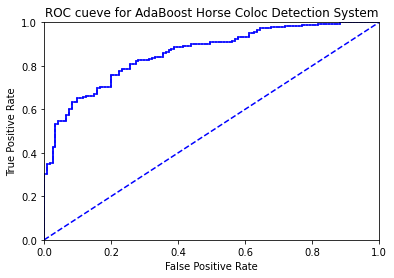

AUC为： 0.8582969635063604


In [65]:
datArr,labelArr = loadDataSet('D:/10-Book/MachineLearninginaction/Ch07/horseColicTraining2.txt')
classifierArray,aggClassEst = adaboostTrainDS(datArr,labelArr,10)
plotROC(aggClassEst.T,labelArr)

### 7.7.2 基于代价函数的分类器决策控制

在分类算法中，有很多方法可以用来引入代价信息。在AdaBoost中，可以基于代价函数来调整错误权重向量D。在朴素贝叶斯中，可以选择具有最小期望代价而不是最大概率的类别作为最后的结果。在SVM中，可以在代价函数中对于不同的类别选择不同的参数c。

### 7.7.3 处理非均衡问题的数据抽样方法
另一种针对非均衡问题调节分类器的方法，就是对分类器的训练数据进行改造。这可以通过欠抽样或者过抽样来实现。过抽样意味着复制样例，欠抽样意味着删除样例。